In [4]:
# This code is specifically designed for Google Colab environment
# It clones a GitHub repository containing medical image processing code and sets up the environment

# Clone the Medical-Image-Processing repository from GitHub using git command
# In Colab, this will clone into the /content directory by default
!git clone https://github.com/RezaSaadatyar/CryptoRangeTrade.git

# List contents of the cloned repository directory to verify successful cloning
# Colab's !ls command shows files in the current directory
!ls /content/CryptoRangeTrade

# Change working directory to the Code subdirectory of the cloned repository
# %cd is a Colab magic command to change directories
%cd /content/CryptoRangeTrade/Code

# Import Python's system module for path manipulation
import sys

# Add the Functions subdirectory to Python's system path for module imports
# This allows importing custom modules from the cloned repository
# sys.path.append('/content/CryptoRangeTrade/Code/Functions')

Cloning into 'CryptoRangeTrade'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 13 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (13/13), 1.96 MiB | 6.40 MiB/s, done.
Code  Data  LICENSE  Pdf  README.md
/content/CryptoRangeTrade/Code


In [5]:
! pip install ta
! pip install mplfinance

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=a8317fd3364f3e44354bebf0fc114daccaf1994cc36a2719e4f33bec2597f5ab
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 8.1 MB/s eta 0:00:00


**Import libraries**

In [6]:
import pandas as pd
import numpy as np
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

from ta import volatility, trend, momentum

**Step 1.1: Load the data**

In [46]:
# Load CSV data
# data = pd.read_csv('C:/Users/rsaad/Downloads/New folder/hourly_BTC.csv')

df = pd.read_csv('/content/CryptoRangeTrade/Data/daily_BTCUSDT.csv', parse_dates=['date'], index_col='date')

# df = pd.read_csv('/content/CryptoRangeTrade/Data/hourly_BTC.csv', parse_dates=['date'], index_col='date')
# del df['Unnamed: 0']

# Drop rows with NaN values
df = df.dropna()

df.head(5)

,open,high,low,close,volume
date,,,,,
2019-01-01,3701.23,3810.16,3642.00,3797.14,23741.687
2019-01-02,3796.45,3882.14,3750.45,3858.56,35156.464
2019-01-03,3857.57,3862.74,3730.00,3766.78,29406.950
2019-01-04,3767.20,3823.64,3703.57,3792.01,29519.555
2019-01-05,3790.09,3840.99,3751.00,3770.96,30490.666


**Step 1.2: Plot financial data**

In [47]:
def plot_financial_data(data, plot_type='candle', days=None, figsize=(8, 6)):
    """
    Plot financial data with customizable display options

    Parameters:
    data: DataFrame
        Financial data with Open, High, Low, Close, Volume columns
    plot_type: str (default: 'candle')
        Chart type: 'candle', 'line', or 'ohlc'
    days: int (default: None)
        Number of recent days to display. If None, shows all data
    figsize: tuple (default: (8, 6))
        Figure size (width, height) in inches
    """
    # Select time range
    plot_data = data if days is None else data[-days:]

    # Style settings
    style = 'charles'

    # Generate automatic title
    title = f"Market Data ({plot_type.capitalize()})"
    if days is not None:
        title += f" - Last {days} Days"

    # Create the plot
    mpf.plot(plot_data,
             type=plot_type,
             style=style,
             title=title,
             ylabel='Price ($)',
             volume=True,
             warn_too_much_data=len(data)+1,
             figratio=figsize,
             figscale=1.0)

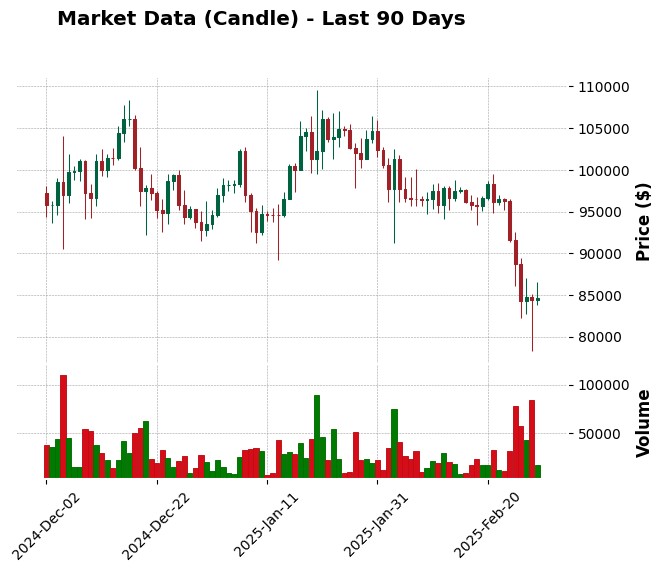

In [48]:
plot_financial_data(df, plot_type='candle', days=90)   # plot_type='line', 'candle' or 'ohlc'

**Step 2: Feature Engineering**

In [49]:
# 1. Price Momentum Features
df['returns_5d'] = df['close'].pct_change(5)  # 5-day returns
df['returns_30d'] = df['close'].pct_change(30)  # 30-day returns
df['momentum_10'] = df['close'] / df['close'].shift(10) - 1

# 2. Volatility Features
df['volatility_10d'] = df['close'].pct_change().rolling(10).std()
df['volatility_30d'] = df['close'].pct_change().rolling(30).std()
df['atr_14'] = volatility.average_true_range(df['high'], df['low'], df['close'], 14)

# 3. Trend Strength Features
df['macd'] = trend.macd(df['close'])
df['ema_50'] = trend.ema_indicator(df['close'], 50)
df['ema_200'] = trend.ema_indicator(df['close'], 200)

# Update features list
features = [
    'open', 'high', 'low', 'close', 'volume',
    'returns_5d', 'returns_30d', 'momentum_10',
    'volatility_10d', 'volatility_30d', 'atr_14',
    'macd', 'ema_50', 'ema_200',
]

# Handle NaN values from feature calculations
df = df.dropna()
df.head(6)

,open,high,low,close,volume,returns_5d,returns_30d,momentum_10,volatility_10d,volatility_30d,atr_14,macd,ema_50,ema_200
date,,,,,,,,,,,,,,
2019-07-19,10628.64,10769.71,10121.84,10504.29,56546.931,0.032446,0.134925,-0.162565,0.072819,0.067754,1041.513913,-1.724348,10055.647557,7027.674442
2019-07-20,10505.78,11068.99,10350.00,10740.23,47331.900,-0.009087,0.128517,-0.112991,0.073356,0.067698,1018.476490,-0.005803,10082.493928,7064.615294
2019-07-21,10740.27,10817.90,10288.00,10589.45,38834.288,0.121812,0.042283,-0.066424,0.070959,0.066785,983.578169,-10.687332,10102.374558,7099.688276
2019-07-22,10590.15,10683.16,10100.00,10340.31,40467.955,0.069549,-0.036273,-0.120514,0.069628,0.066206,954.976872,-38.808675,10111.705360,7131.933268
2019-07-23,10343.08,10343.97,9822.00,9864.91,47624.371,-0.071727,-0.095466,-0.131286,0.070173,0.066680,924.047809,-98.322449,10102.027110,7159.127067
2019-07-24,9864.78,9937.00,9525.00,9763.28,43475.378,-0.070544,-0.116972,-0.040387,0.062284,0.066639,887.472966,-151.936802,10088.742910,7185.039036


**Step 3: Label Creation (Trending = 1, Range = 0)**

In [50]:
data = df
window_size = 5
data['price_change'] = data['close'].pct_change(window_size)
data['label'] = np.where(abs(data['price_change']) > 0.05, 1, 0)  # 3% change = trend

# window_size = 300
# data['price_change'] = data['close'].pct_change(window_size)
# data['label'] = np.where(abs(data['price_change']) > 0.09, 1, 0)  # 3% change = trend

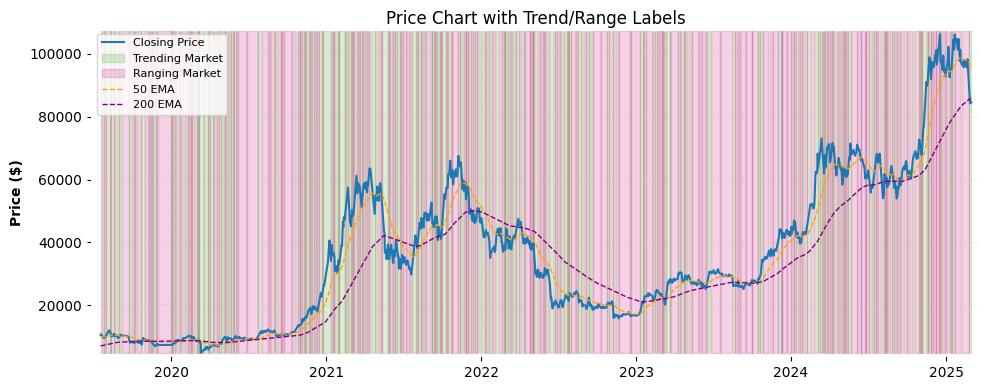

In [51]:
plt.figure(figsize=(10, 4))  # Wider figure for better timeseries display

plt.plot(data.index, data['close'],
        color='#1f77b4',
        linewidth=1.5,
        label='Closing Price')

# Highlight market regimes
trend_mask = data['label'] == 1
range_mask = data['label'] == 0

plt.fill_between(data.index,
                data['close'].min()*0.99,
                data['close'].max()*1.01,
                where=trend_mask,
                color='#4dac26',  # Green
                alpha=0.2,
                label='Trending Market')
plt.fill_between(data.index,
                data['close'].min()*0.99,
                data['close'].max()*1.01,
                where=range_mask,
                color='#d01c8b',  # Pink
                alpha=0.2,
                label='Ranging Market')

# Add moving averages
plt.plot(data.index, data['ema_50'],
        '--',
        color='orange',
        linewidth=1,
        label='50 EMA')
plt.plot(data.index, data['ema_200'],
        '--',
        color='purple',
        linewidth=1,
        label='200 EMA')

# Formatting
plt.title('Price Chart with Trend/Range Labels', fontsize=12, pad=1)
plt.ylabel('Price ($)', fontsize=10)
plt.legend(loc='upper left', fontsize=8)
plt.grid(True, linestyle=':', alpha=0.5)
plt.margins(x=0.01, y=0.01) # Reduce padding around the plot
plt.tight_layout(pad=1.0)
plt.tight_layout()
plt.show()

**Step 4: Prepare Data for Modeling**

In [52]:
X = data[features]
y = data['label']

# Split data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

split_date = data.index[int(len(data)*0.8)]
X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]
y_train = y[y.index < split_date]
y_test = y[y.index >= split_date]

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train period: {X_train.index.min()} to {X_train.index.max()}")
print(f"Test period: {X_test.index.min()} to {X_test.index.max()}")
print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")

Train period: 2019-07-19 00:00:00 to 2024-01-21 00:00:00
Test period: 2024-01-22 00:00:00 to 2025-03-01 00:00:00
Train samples: 1618, Test samples: 405


**Step 5: Model Training and Evaluation**

In [53]:
def train_and_evaluate(model, model_name, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # For models that support predict_proba
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)
    else:
        roc_auc = None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n{model_name} Performance:")
    # Print the accuracy metric - overall correctness of predictions
    # Formula: (TP + TN) / (TP + TN + FP + FN)
    print("Accuracy:", accuracy)

    # Print the precision metric - correctness when predicting positive class
    # Formula: TP / (TP + FP)
    print("Precision:", precision)

    # Print the recall metric - ability to find all positive cases
    # Formula: TP / (TP + FN)
    print("Recall:", recall)

    # Print the F1 Score - harmonic mean of precision and recall
    # Formula: 2 * (precision * recall) / (precision + recall)
    print("F1 Score:", f1)

    if roc_auc is not None:
        print("ROC AUC Score:", roc_auc)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(learning_rate=0.01, n_estimators=500, random_state=42, eval_metric='logloss')
}

In [54]:
# Train and evaluate each model
results = []
for name, model in models.items():
    result = train_and_evaluate(model, name, X_train_scaled, X_test_scaled, y_train, y_test)
    results.append(result)

# Convert results to DataFrame for comparison
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df[['model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']])


Logistic Regression Performance:
Accuracy: 0.6419753086419753
Precision: 0.625
Recall: 0.22012578616352202
F1 Score: 0.32558139534883723
ROC AUC Score: 0.6935368410287877

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.91      0.76       246
           1       0.62      0.22      0.33       159

    accuracy                           0.64       405
   macro avg       0.63      0.57      0.54       405
weighted avg       0.64      0.64      0.59       405

Confusion Matrix:
[[225  21]
 [124  35]]

Random Forest Performance:
Accuracy: 0.9975308641975309
Precision: 0.99375
Recall: 1.0
F1 Score: 0.9968652037617555
ROC AUC Score: 0.9999744337066013

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       246
           1       0.99      1.00      1.00       159

    accuracy                           1.00       405
   macro avg       1.00      1.00      1.00

In [55]:
# Feature Importance
print("\nFeature Importances:")
for name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        print(f"\n{name} Feature Importances:")
        importance = pd.DataFrame({
            'feature': features,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        print(importance)


Feature Importances:

Random Forest Feature Importances:
           feature  importance
5       returns_5d    0.611950
7      momentum_10    0.069767
8   volatility_10d    0.061567
4           volume    0.036997
9   volatility_30d    0.035887
6      returns_30d    0.029747
10          atr_14    0.023936
13         ema_200    0.021770
11            macd    0.021384
12          ema_50    0.020803
1             high    0.017921
3            close    0.017014
2              low    0.015983
0             open    0.015274

XGBoost Feature Importances:
           feature  importance
5       returns_5d    0.899696
4           volume    0.028408
7      momentum_10    0.011998
8   volatility_10d    0.011102
9   volatility_30d    0.009913
11            macd    0.009787
13         ema_200    0.009309
6      returns_30d    0.008291
1             high    0.006075
12          ema_50    0.005422
2              low    0.000000
3            close    0.000000
0             open    0.000000
10          a